In [1]:
using LinearAlgebra, Random, PyPlot
rc("axes.spines", top=false, right=false)

In [2]:
# Equality Constrained Quadratic Programming
function solve_quad_prog(P, q, A, b)
    """
    minimize   : 1/2 * x'*P*x + q'*x
    subject to : A*x = b
    """
    K = [P A'; A zeros(size(A)[1], size(A)[1])] # KKT matrix
    sol = K \ [-q; b]
    return sol[1:size(A)[2]]
end;

In [3]:
function minimum_variance_model(Ac, Bc, x0, xf, tf, tp, dt)
    dims = size(x0)[1]
    ntf = round(Int, tf/dt)
    ntp = round(Int, tp/dt)
    nt = ntf + ntp # total time steps    
    
    A = I(dims) + Ac * dt
    B = Bc*dt
    #A = exp(Ac*dt);
    #B = Ac^-1 * (I(dims) - A) *Bc; 
    
    # calculation of V
    diagV = zeros(nt);
    for t=0:nt-1
        if t < ntf
            diagV[t+1] = sum([(A^(k-t-1) * B * B' * A'^(k-t-1))[1,1] for k=ntf:nt-1])
        else
            diagV[t+1] = diagV[t] + (A^(nt-t-2) * B * B' * A'^(nt-t-2))[1,1]
        end
    end
    diagV /= maximum(diagV) # for numerical stability
    V = Diagonal(diagV); 
    
    # 制約条件における行列Cとベクトルdの計算
    #calculation of C
    C = zeros(dims*(ntp+1), nt);
    for p=1:ntp+1
        for q=1:nt
            if ntf-1+(p-1)-(q-1) >= 0
                idx = dims*(p-1)+1:dims*p
                C[idx, q] = A^(ntf-1-(q-1)+(p-1)) * B # if ntf-1-(q-1)+(p-1) == 0; A^(ntf-1-(q-1)+(p-1))*B equal to B
            end
        end
    end
    
    # calculation of d
    d = vcat([xf - A^(ntf+t) * x0 for t=0:ntp]...);
    
    # 制御信号を二次計画法で計算 (solution by quadratic programming)
    u = solve_quad_prog(V, zeros(nt), C, d);
    
    # 制御信号を二次計画法で計算 (forward solution)
    x = zeros(dims, nt);
    x[:,1] = x0;
    Σ = zeros(dims, dims, nt);
    Σ[:, :, 1] = B * u[1]^2 * B'
    for t=1:nt-1
        x[:,t+1] = A*x[:, t] + B*u[t] # update
        Σ[:, :, t+1] = A * Σ[:, :, t] * A' + B * u[t]^2 * B' # variance
    end
    return x, u, Σ
end

minimum_variance_model (generic function with 1 method)

In [4]:
t1 = 224*1e-3 # time const of eye dynamics (s)
t2 = 13*1e-3  # another time const of eye dynamics (s)
tm = 10*1e-3
dt = 1e-3     # simulation time step (s)
tf = 50*1e-3  # movement duration (s)
tp = 40*1e-3  # post-movement duration (s)
nt = round(Int, (tf+tp)/dt) # total time steps
trange = (1:nt) * dt * 1e3 # ms

# 2nd order
x0₂ = zeros(2) # initial state (pos=0, vel=0)
xf₂ = [10, 0]  # final state (pos=10, vel=0)
Ac₂ = [0 1; -1/(t1*t2) -1/t1-1/t2];
Bc₂ = [0, 1]

# 3rd order
x0₃ = zeros(3)   # initial state (pos=0, vel=0, acc=0)
xf₃ = [10, 0, 0] # final state (pos=10, vel=0, acc=0)
Ac₃ = [0 1 0; 0 0 1; -1/(t1*t2*tm) -1/(t1*t2)-1/(t1*tm)-1/(t2*tm) -1/t1-1/t2-1/tm];
Bc₃ = [0, 0, 1/tm];

In [5]:
x₂, u₂, Σ₂ = minimum_variance_model(Ac₂, Bc₂, x0₂, xf₂, tf, tp, dt);
x₃, u₃, Σ₃ = minimum_variance_model(Ac₃, Bc₃, x0₃, xf₃, tf, tp, dt);

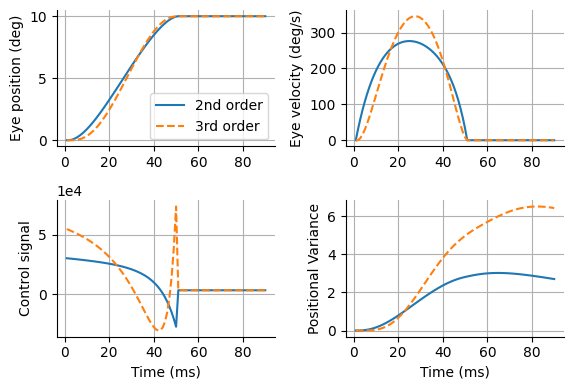

In [6]:
figure(figsize=(6, 4))
subplot(2,2,1); plot(trange, x₂[1, :], label="2nd order"); plot(trange, x₃[1, :], "--", label="3rd order"); 
ylabel("Eye position (deg)"); grid(); legend()
subplot(2,2,2); plot(trange, x₂[2, :]); plot(trange, x₃[2, :], "--"); 
ylabel("Eye velocity (deg/s)"); grid();
subplot(2,2,3); plot(trange, u₂); plot(trange, u₃, "--");
ylabel("Control signal"); xlabel("Time (ms)"); grid();
ax = gca(); ax[:ticklabel_format](style="sci",axis="y",scilimits=(0,0))
subplot(2,2,4); plot(trange, Σ₂[1,1,:]); plot(trange, Σ₃[1,1,:], "--");
ylabel("Positional Variance"); xlabel("Time (ms)"); grid()
tight_layout()